[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/vae/vae_ffnn.ipynb)


In [ ]:
import torch
import cv2
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **DataSet**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True, num_workers=0) # loading the downloaded dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 103641567.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43278204.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28500570.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16696344.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Modelling**

In [ ]:
class VAEModel(nn.Module):
    def __init__(self):
        super(VAEModel, self).__init__()

        self.encoder_fc = nn.Sequential(nn.Linear(28*28, 196),nn.Tanh(),
                                       nn.Linear(196, 48),nn.Tanh(),)
        self.mean_fc = nn.Sequential(nn.Linear(48, 16), nn.Tanh(),
                                     nn.Linear(16, 2))
        self.log_var_fc = nn.Sequential(nn.Linear(48, 16),nn.Tanh(),
                                        nn.Linear(16, 2))
        self.decoder_fcs = nn.Sequential(nn.Linear(2, 16),nn.Tanh(),
                                         nn.Linear(16, 48),nn.Tanh(),
                                         nn.Linear(48, 196),nn.Tanh(),
                                         nn.Linear(196, 28*28),nn.Tanh()) # tan because initially we are converting image from -1 to 1 and hence predected should also be between -1 to 1

    def forward(self, x):

        #Encoder
        out = self.encoder_fc(torch.flatten(x, start_dim=1))
        mean = self.mean_fc(out)
        log_var = self.log_var_fc(out)

        ## Sampling
        std = torch.exp(0.5 * log_var)
        z = torch.randn_like(std)*std + mean

        ## Decoder
        out = self.decoder_fcs(z)
        out = out.reshape((z.size(0), 1, 28, 28))

        return mean, log_var, out

# **Training**

In [ ]:
model = VAEModel().to(device)
optimizer = Adam(model.parameters(), lr=1E-3)

In [ ]:
for epoch_idx in range(10): # Run training for 10 epochs

    recon_losses = []
    kl_losses = []
    losses = []

    for im, _ in tqdm(mnist_loader):

        im = im.float().to(device)
        optimizer.zero_grad()
        mean, log_var, out = model(im)

        # loss calculation
        kl_loss = torch.mean(0.5* torch.sum(torch.exp(log_var) + mean**2 - 1 -log_var, dim=-1))
        recon_loss = torch.nn.MSELoss()(out, im)
        loss = recon_loss + 0.00001 * kl_loss

        # housekeeping
        recon_losses.append(recon_loss.item())
        losses.append(loss.item())
        kl_losses.append(kl_loss.item())

        loss.backward()
        optimizer.step()

    print(f'''Finished epoch:{epoch_idx+1} | Recon Loss : {np.mean(recon_losses)} | KL Loss : {np.mean(kl_losses)}''')

100%|██████████| 938/938 [00:14<00:00, 63.46it/s]


Finished epoch:1 | Recon Loss : 0.2558444815435643 | KL Loss : 4.172774832497146


100%|██████████| 938/938 [00:14<00:00, 64.38it/s]


Finished epoch:2 | Recon Loss : 0.2280437888573609 | KL Loss : 6.335120561844441


100%|██████████| 938/938 [00:15<00:00, 62.30it/s]


Finished epoch:3 | Recon Loss : 0.21321157766367071 | KL Loss : 7.728291119630869


100%|██████████| 938/938 [00:17<00:00, 52.95it/s]


Finished epoch:4 | Recon Loss : 0.2037242973830972 | KL Loss : 8.61793437228004


100%|██████████| 938/938 [00:17<00:00, 53.40it/s]


Finished epoch:5 | Recon Loss : 0.1969620187558345 | KL Loss : 9.253313285731938


100%|██████████| 938/938 [00:14<00:00, 63.95it/s]


Finished epoch:6 | Recon Loss : 0.19184671620114865 | KL Loss : 9.730310025687814


100%|██████████| 938/938 [00:14<00:00, 63.79it/s]


Finished epoch:7 | Recon Loss : 0.18785352639779063 | KL Loss : 10.082839096766708


100%|██████████| 938/938 [00:14<00:00, 62.86it/s]


Finished epoch:8 | Recon Loss : 0.18462830170520397 | KL Loss : 10.374066216428318


100%|██████████| 938/938 [00:14<00:00, 63.24it/s]


Finished epoch:9 | Recon Loss : 0.18194803017641917 | KL Loss : 10.61125485967775


100%|██████████| 938/938 [00:15<00:00, 61.55it/s]

Finished epoch:10 | Recon Loss : 0.1796555573323261 | KL Loss : 10.804456319138884


# **Inference**

In [ ]:
# Getting 100 random indexes
idxs = torch.randint(0, len(mnist)-1, (100, ))

# using these indexes to get images from mnist dataset and concatenating them
test_ims = torch.cat([mnist[idx][0][None, :] for idx in idxs]).float()

# generating images for the above test dataset
_, _, generated_im = model(test_ims.to(device))

In [ ]:
generated_im = torch.clamp(generated_im, -1., 1.).detach().cpu() # clamping the generated images
generated_im = 0.5*generated_im + 0.5 #detransforming the images from [-1,1] to [0,1]

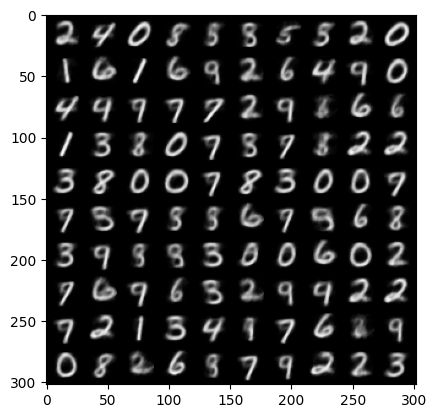

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_im, nrow=10)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray')